In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import os
import sys
import datetime
import gc
from glob import glob

# import cv2
# from cv2 import IMREAD_COLOR
# from PIL import Image
# import torchvision.transforms as transforms

# from matplotlib.colors import ListedColormap
# from histomicstk.saliency.tissue_detection import (
#     get_slide_thumbnail, get_tissue_mask)

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

In [4]:
train_meta = pd.read_csv(f'{CFG.DATA_PATH}/train_metadata.csv')
test_meta = pd.read_csv(f'{CFG.DATA_PATH}/test_metadata.csv')
train_labels = pd.read_csv(f'{CFG.DATA_PATH}/train_labels.csv')
test_labels = pd.read_csv(f'{CFG.DATA_PATH}/test_labels.csv')
annot = pd.read_csv(f'{CFG.DATA_PATH}/annotations.csv')

In [6]:
train_meta.loc[0, 'us_tif_url']

's3://drivendata-competition-visiomel-public-us/images/1u4lhlqb.tif'

In [13]:
from multiprocessing import Queue, Pool, Process
from concurrent.futures import ProcessPoolExecutor

muq = Queue()
stdq = Queue()
fq = Queue()
files = glob(f'{CFG.DATA_PATH}/images/*')

def stdmean(fileq, mq, sq):
    empty = False
    while not empty:
        if fq.empty():
            empty = True
                   
        file = fileq.get()
        img = cv2.imread(file, IMREAD_COLOR) / 255

        (mean, std) = cv2.meanStdDev(img)

        mq.put(mean)
        sq.put(std)

        del img

for file in files:
    fq.put(file)

ps = []
for _ in range(8):
    p = Process(target=stdmean, args=[fq, muq, stdq])
    ps.append(p)
    p.start()

for p in ps:
    p.join()

KeyboardInterrupt: 

In [4]:
def calc_mean(q):
    total = 0
    l = []
    while True:
        if q.empty():
            return np.mean(np.array(l), axis=0), l
        num = q.get()
        l.append(num)

In [5]:
mumean, mulist = calc_mean(muq)
stdmean, stdlist = calc_mean(stdq)

NameError: name 'muq' is not defined

In [3]:
def preprocess(img: Image):
    
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CFG.MUMEAN, CFG.STDMEAN)
])
    img_tr = transform(img)
    
    # Convert tensor image to numpy array
    return np.array(img_tr)

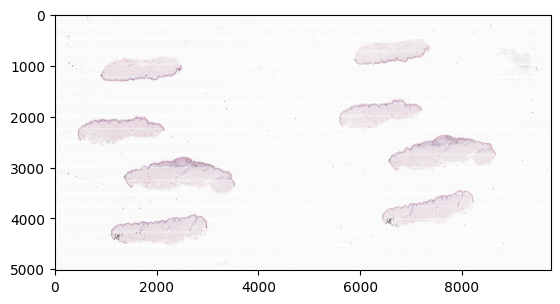

In [4]:
img = Image.open(f'{CFG.DATA_PATH}/images/1u4lhlqb.jpg')
img2 = preprocess(img)
img2 = img2.transpose(1, 2, 0)
plt.imshow(img)

In [5]:
img = Image.open(f'{CFG.DATA_PATH}/images/1u4lhlqb.jpg')
data = np.asarray(img2)

labeled, mask = get_tissue_mask(
    data, deconvolve_first=False,
    n_thresholding_steps=1, sigma=0., min_size=200)

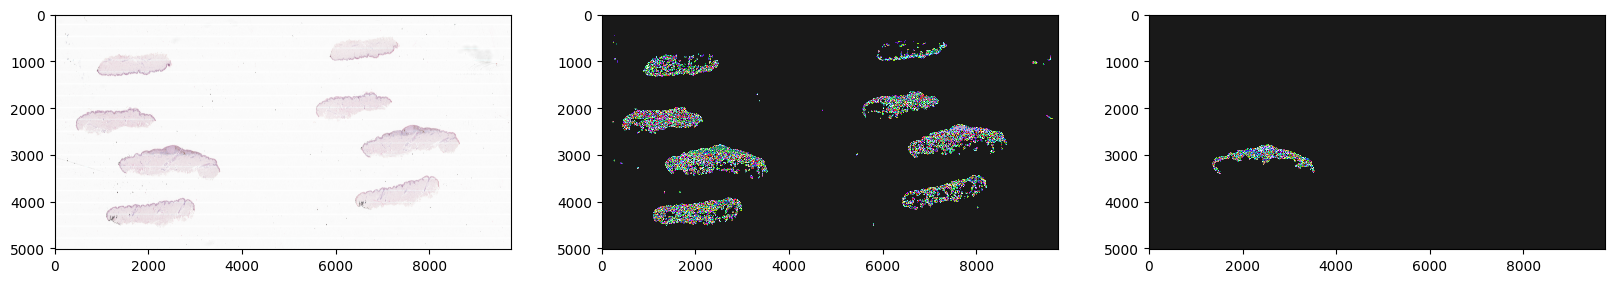

In [6]:
vals = np.random.rand(256,3)
vals[0, ...] = [0.9, 0.9, 0.9]
cMap = ListedColormap(1 - vals)

f, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img)
ax[1].imshow(labeled, cmap=cMap) # all tissue regions
ax[2].imshow(mask, cmap=cMap) # largest tissue region
plt.show()